In [2]:
import random
import collections
import math
import os
import zipfile
import re

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.contrib.tensorboard.plugins import projector
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
dataset_link = 'http://mattmahoney.net/dc'
zip_file = 'text8.zip'

def data_download(zip_file):
    if not os.path.exists(zip_file):
        zip_file,_ = urlretrieve(dataset_link+zip_file,zip_file)
        print("File download successfully")
    return None

data_download(zip_file) 

In [4]:
extracted_folder = 'dataset'

if not os.path.isdir(extracted_folder):
    with zip_file.ZipFile(zip_file) as zf:
        zf.extractall(extracted_folder) 

In [5]:
with open('dataset/text8') as ft_:
    full_text = ft_.read() 

In [6]:
def text_processing(ft8_text):
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.',' <period> ')
    ft8_text = ft8_text.replace(',',' <comma> ')
    ft8_text = ft8_text.replace('"',' <quotation> ')
    ft8_text = ft8_text.replace(';',' <semicolon> ')
    ft8_text = ft8_text.replace('!',' <exclamation> ')
    ft8_text = ft8_text.replace('?',' <question> ')
    ft8_text = ft8_text.replace('(',' <paren_l> ')
    ft8_text = ft8_text.replace(')',' <paren_r> ')
    ft8_text = ft8_text.replace('--',' <hyphen> ')
    ft8_text = ft8_text.replace(':',' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [7]:
ft_tokens = text_processing(full_text)

word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7] 

In [8]:
def dict_creation(shortlisted_words):
    counts = collections.Counter(shortlisted_words)
    vocabulary = sorted(counts,key=counts.get,reverse=True)
    rev_dictionary_ = {ii:word for ii,word in enumerate(vocabulary)}
    dictionary_ = {word:ii for ii,word in rev_dictionary_.items()}
    
    return dictionary_,rev_dictionary_

In [9]:
dictionary_,rev_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words]

## CBOW

In [10]:
data_index = 0

def cbow_batch_creation(batch_length,word_window):
    global data_index
    
    relevant_words = 2 * word_window + 1
    
    batch = np.ndarray(shape=(batch_length,relevant_words-1),dtype=np.int32)
    label_ = np.ndarray(shape=(batch_length,1),dtype=np.int32)
    
    buffer = collections.deque(maxlen=relevant_words)
    
    for _ in range(relevant_words):
        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)
        
    for i in range(batch_length):
        target = word_window
        target_to_avoid = [word_window]
        
        col_idx = 0
        for j in range(relevant_words):
            if j==relevant_words //2 :
                continue
            batch[i,col_idx] = buffer[j]
            col_idx += 1
        label_[i,0] = buffer[target]
        
        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)
        
    assert batch.shape[0] == batch_length and batch.shape[1] == relevant_words - 1
    return batch,label_

In [11]:
for num_skips,word_window in [(2,1),(4,2)]:
    data_index = 0
    batch,label_ = cbow_batch_creation(batch_length=8,word_window=word_window)
    print('\nwith num_skips = %d and word_window = %d:'%(num_skips,word_window))
    print('   batch:',[[rev_dictionary_[bii] for bii in bi] for bi in batch])
    print('   label_:',[rev_dictionary_[li] for li in label_.reshape(8)]) 


with num_skips = 2 and word_window = 1:
   batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
   label_: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and word_window = 2:
   batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
   label_: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [12]:
num_steps = 100001

batch_length = 128
embedding_size = 128
skip_window = 1
num_skips = 2

In [14]:
tf_cbow_graph = tf.Graph()

with tf_cbow_graph.as_default():
    validation_cnt = 16
    validation_dict = 100
    
    validation_words = np.array(random.sample(range(validation_dict),validation_cnt//2))
    validation_words = np.append(validation_words,random.sample(range(1000,1000+validation_dict),validation_cnt//2))
    
    train_dataset = tf.placeholder(tf.int32,shape=[batch_length,2*skip_window])
    train_labels = tf.placeholder(tf.int32,shape=[batch_length,1])
    validation_data = tf.constant(validation_words,dtype=tf.int32)

In [16]:
with tf_cbow_graph.as_default():
    vocabulary_size = len(rev_dictionary_)
    
    word_embed = tf.Variable(tf.random_uniform([vocabulary_size,embedding_size],-1.0,1.0))
    
    context_embeddings = []
    
    for i in range(2*skip_window):
        context_embeddings.append(tf.nn.embedding_lookup(word_embed,train_dataset[:,i]))
        
    embedding = tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keepdims=False)   

In [17]:
with tf_cbow_graph.as_default():
    sf_weights = tf.Variable(tf.truncated_normal([vocabulary_size,embedding_size],
                                                 stddev=1.0/math.sqrt(embedding_size)))
    sf_bias = tf.Variable(tf.zeros([vocabulary_size]))
    
    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights,biases=sf_bias,inputs=embedding,
                                        labels=train_labels,num_sampled=64,num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    optim = tf.train.AdagradOptimizer(1.0).minimize(cost_fn)  

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [18]:
with tf_cbow_graph.as_default():
    
    normalization_embed = word_embed / tf.sqrt(tf.reduce_sum(tf.square(word_embed),1,keepdims=True))
    validation_embed = tf.nn.embedding_lookup(normalization_embed,validation_data)
    word_similarity = tf.matmul(validation_embed,tf.transpose(normalization_embed)) 

In [22]:
with tf.Session(graph=tf_cbow_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_loss = 0
    for step in range(num_steps):
        batch_words, batch_label_ = cbow_batch_creation(batch_length,skip_window)
        _,l = sess.run([optim,loss_fn],feed_dict={train_dataset:batch_words,train_labels:batch_label_})
        avg_loss += l
        
        if step % 2000 ==0:
            if step > 0 :
                avg_loss = avg_loss / 2000
            print('Average loss at step %d: %f' % (step,np.mean(avg_loss)))
            avg_loss = 0
        
        if step % 10000 == 0:
            sim = word_similarity.eval() 
            for i in range(validation_cnt):
                valid_word = rev_dictionary_[validation_words[i]]
                top_k = 8
                nearest = (-sim[i,:]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = rev_dictionary_[nearest[k]]
                    log = '%s %s,' % (log,close_word)
                print(log)
    final_embeddings = normalization_embed.eval() 

Average loss at step 0: 7.758416
Nearest to at: shattered, canal, bourke, browns, atlases, consequently, forster, tetrapods,
Nearest to see: shuffle, airspace, decentralized, reagan, sourcewatch, recreate, dz, circumstance,
Nearest to nine: magellan, modifications, antlia, terminal, dn, misdemeanor, widespread, preliminary,
Nearest to or: crusade, allows, oath, lashes, harmon, kauffman, shipper, protocols,
Nearest to for: packing, boulogne, smallville, carnatic, crashing, abstention, congregationalist, gown,
Nearest to where: monika, mick, vitruvius, woodsman, organizer, constructive, occupations, hush,
Nearest to its: telford, placid, presbyterian, zhejiang, unipolar, widen, forbidden, ursidae,
Nearest to eight: sixteen, yeti, payloads, inflection, cinq, abad, stabbing, halogen,
Nearest to writers: heckler, correctly, smtp, crocker, hillbillies, storming, scilly, domicile,
Nearest to bbc: bobtail, sikh, lowball, algorism, chukchi, bhishma, boardwalk, barberini,
Nearest to channel: cir

Average loss at step 52000: 2.869172
Average loss at step 54000: 2.897456
Average loss at step 56000: 2.816433
Average loss at step 58000: 2.805845
Average loss at step 60000: 2.828248
Nearest to at: during, in, near, orser, canal, overlords, rwandan, obstructive,
Nearest to see: segr, turquoise, pogues, include, dubious, gaulish, thrones, modus,
Nearest to nine: eight, seven, six, five, four, zero, three, two,
Nearest to or: and, than, chloroform, surrendered, transporting, usbc, boon, wic,
Nearest to for: without, versus, accidently, packing, iconography, trifluoride, rags, trintignant,
Nearest to where: when, although, tlatoani, carmack, token, because, if, caspase,
Nearest to its: their, his, her, the, your, whose, our, encryption,
Nearest to eight: nine, seven, six, five, four, three, zero, two,
Nearest to writers: smtp, crocker, specialties, scilly, roda, football, marathas, domicile,
Nearest to bbc: unofficially, noses, dispositions, scania, hatta, westcott, roux, clemente,
Near

In [23]:
num_points = 250

tsne = TSNE(perplexity=30,n_components=2,init='pca',n_iter=5000)
embeddings_2d = tsne.fit_transform(final_embeddings[1:num_points+1,:]) 

In [30]:
def cbow_plot(embeddings,labels):
    assert embeddings.shape[0] >= len(labels), "More labels than embeddings"
    pylab.figure(figsize=(12,12))
    
    for i,label in enumerate(labels):
        x,y = embeddings[i,:]
        pylab.scatter(x,y)
        pylab.annotate(label,xy=(x,y),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
    pylab.show()

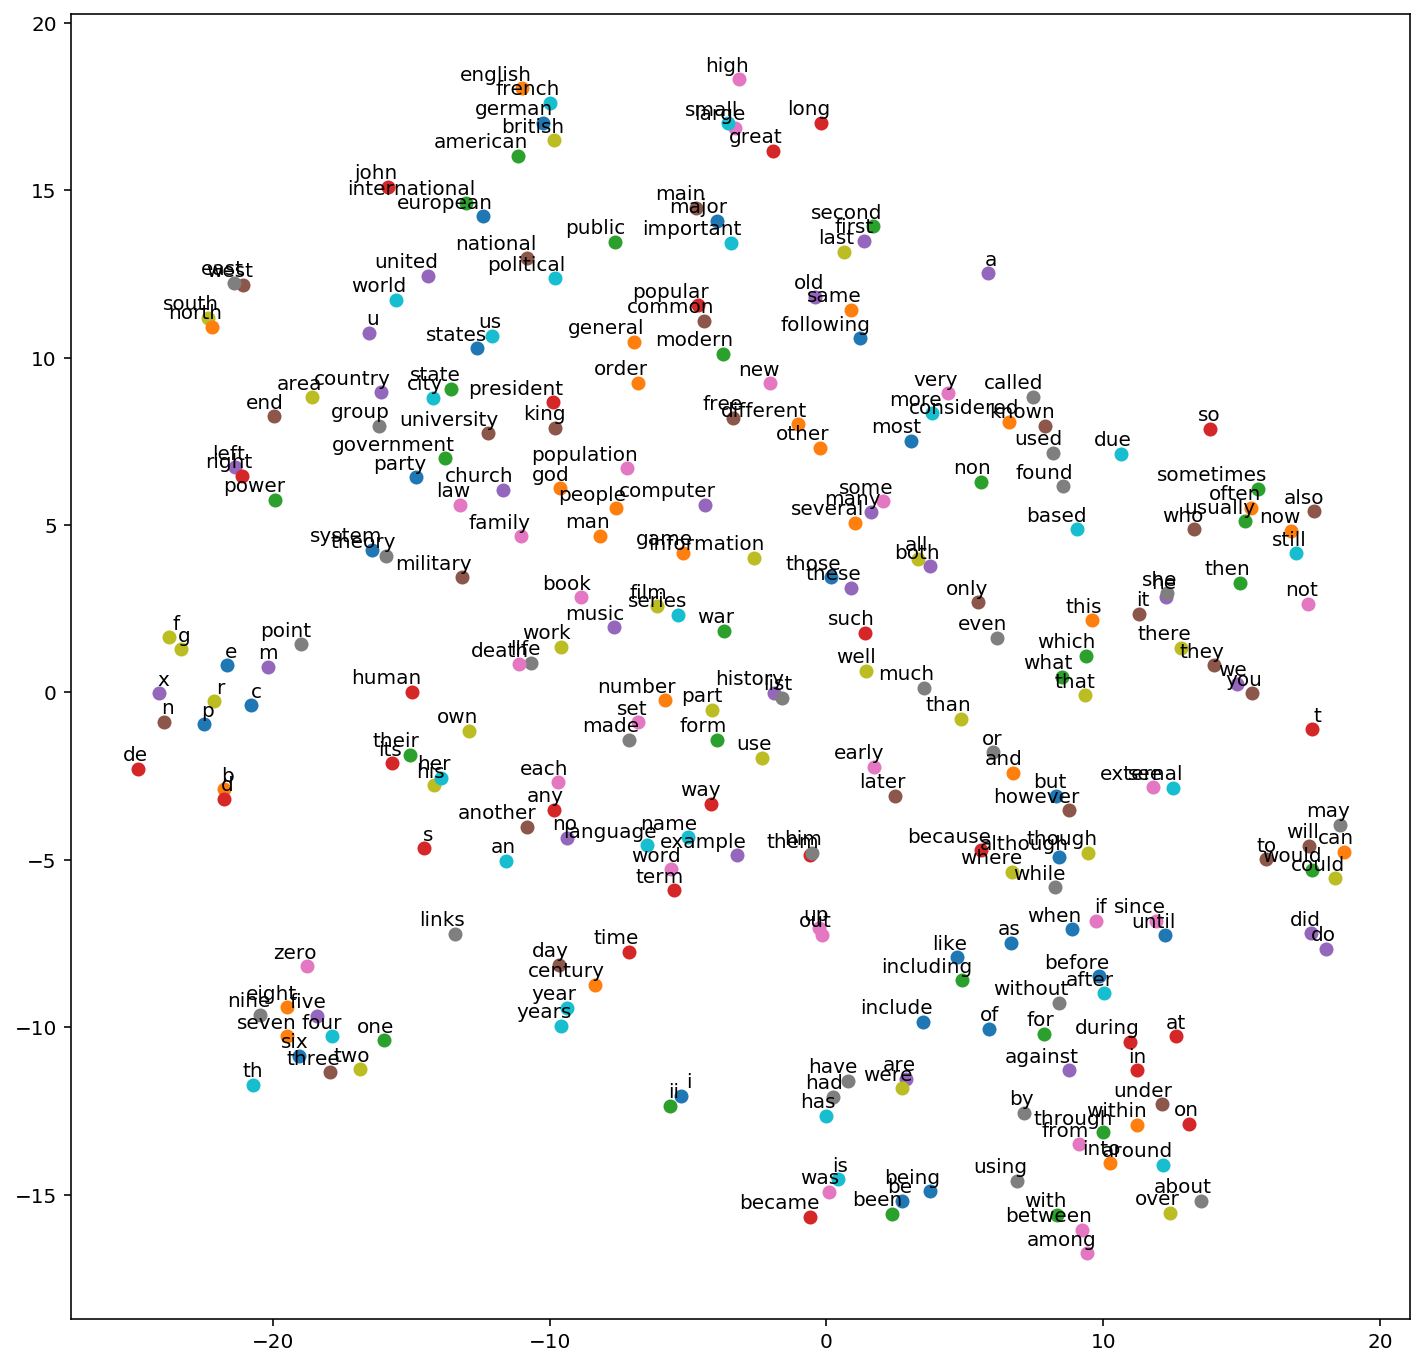

In [31]:
words = [rev_dictionary_[i] for i in range(1,num_points+1)]
cbow_plot(embeddings_2d,words) 